# Simple Model
The aim of this workbook it to take an extremely simplified version of the model (just debris) and then build the equations and solve for them to ensure that the model is working correctly before implementing.

In [2]:
import dill as pickle
import sympy as sp
import pandas as pd
import scipy as sc
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import os   

In [366]:
with open(os.path.join(os.getcwd(), '../../scenario_properties-long.pkl'), 'rb') as f:
    scenario_properties = pickle.load(f)

In [320]:
scenario_properties.species_names = [i.replace('.', 'p') for i in scenario_properties.species_names]
scenario_properties.species_names

['S_148kg',
 'S_750kg',
 'S_1250kg',
 'Su_260kg',
 'Su_473kg',
 'Sns',
 'N_0p00141372kg',
 'N_0p567kg',
 'N_6kg',
 'N_148kg',
 'N_260kg',
 'N_473kg',
 'N_750kg',
 'N_1250kg',
 'B']

In [367]:
# Lambdafiying the equations
symbols = scenario_properties.all_symbolic_vars

equations_flattened = [scenario_properties.equations[i, j] for j in range(scenario_properties.equations.cols) for i in range(scenario_properties.equations.rows)]
#drag_flattened = [scenario_properties.full_drag[i, j] for j in range(scenario_properties.full_drag.cols) for i in range(scenario_properties.full_drag.rows)]
#pmd_flattened = [scenario_properties.full_Cdot_PMD[i, j] for j in range(scenario_properties.full_Cdot_PMD.cols) for i in range(scenario_properties.full_Cdot_PMD.rows)]
#collisions_flattened = [scenario_properties.full_coll[i, j] for j in range(scenario_properties.full_coll.cols) for i in range(scenario_properties.full_coll.rows)]

# Convert equations to lambda functions
equations = [sp.lambdify(symbols, eq, 'numpy') for eq in equations_flattened]
#full_drag = [sp.lambdify(symbols, eq, 'numpy') for eq in drag_flattened]
#full_pmd = [sp.lambdify(symbols, eq, 'numpy') for eq in pmd_flattened]
#full_coll = [sp.lambdify(symbols, eq, 'numpy') for eq in collisions_flattened]

full_lambda_flattened = []

for i in range(len(scenario_properties.full_lambda)):
    if scenario_properties.full_lambda[i] is not None:
        full_lambda_flattened.extend(scenario_properties.full_lambda[i])
    else:
        # Append None to the list, length of scenario_properties.n_shells
        full_lambda_flattened.extend([None]*scenario_properties.n_shells)

In [368]:
x0_flattened = scenario_properties.x0.T.values.flatten()
times = np.array(scenario_properties.scen_times)

# Same funciton but uses np.interp
def population_shell(t, N, full_lambda, equations):
    print(t)
    # Initialize the rate of change array
    dN_dt = np.zeros_like(N)

    for i in range(len(N)):
        if full_lambda[i] is not None:
            increase = np.interp(t, times, full_lambda[i])
            # If increase is nan set to 0
            if np.isnan(increase):
                dN_dt[i] += 0
            else:
                dN_dt[i] += increase

            # Compute the intrinsic rate of change from the differential equation
        dN_dt[i] += equations[i](*N)

    return dN_dt

output = solve_ivp(population_shell, [scenario_properties.scen_times[0], scenario_properties.scen_times[-1]], x0_flattened, 
                    args=(full_lambda_flattened, equations), 
                    t_eval=scenario_properties.scen_times, method='BDF')

0.0
2.3627004624313678e-07
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0

In [370]:
scenario_properties.equations[:, 4]

Matrix([
[                              -4.37347127147578e-12*pi*B_1*Su_473kg_1 - 8.39298307814122e-8*pi*N_0.00141372kg_1*Su_473kg_1 - 9.40343514877153e-13*pi*N_0.567kg_1*Su_473kg_1 - 7.11317994179044e-12*pi*N_1250kg_1*Su_473kg_1 - 1.27951796598535e-12*pi*N_148kg_1*Su_473kg_1 - 1.51592799913287e-12*pi*N_260kg_1*Su_473kg_1 - 3.32510832660952e-12*pi*N_473kg_1*Su_473kg_1 - 9.17883420670727e-13*pi*N_6kg_1*Su_473kg_1 - 3.20194971587162e-12*pi*N_750kg_1*Su_473kg_1 - 7.11317994179044e-17*pi*S_1250kg_1*Su_473kg_1 - 1.27951796598535e-17*pi*S_148kg_1*Su_473kg_1 - 3.20194971587162e-17*pi*S_750kg_1*Su_473kg_1 - 9.17883420670727e-13*pi*Sns_1*Su_473kg_1 - 1.51592799913287e-17*pi*Su_260kg_1*Su_473kg_1 - 6.65021665321903e-17*pi*Su_473kg_1**2 - 0.125*Su_473kg_1],
[                              -4.33394112958679e-12*pi*B_2*Su_473kg_2 - 8.31712209921707e-8*pi*N_0.00141372kg_2*Su_473kg_2 - 9.31844107824927e-13*pi*N_0.567kg_2*Su_473kg_2 - 7.04888661620835e-12*pi*N_1250kg_2*Su_473kg_2 - 1.26795289018966e-12

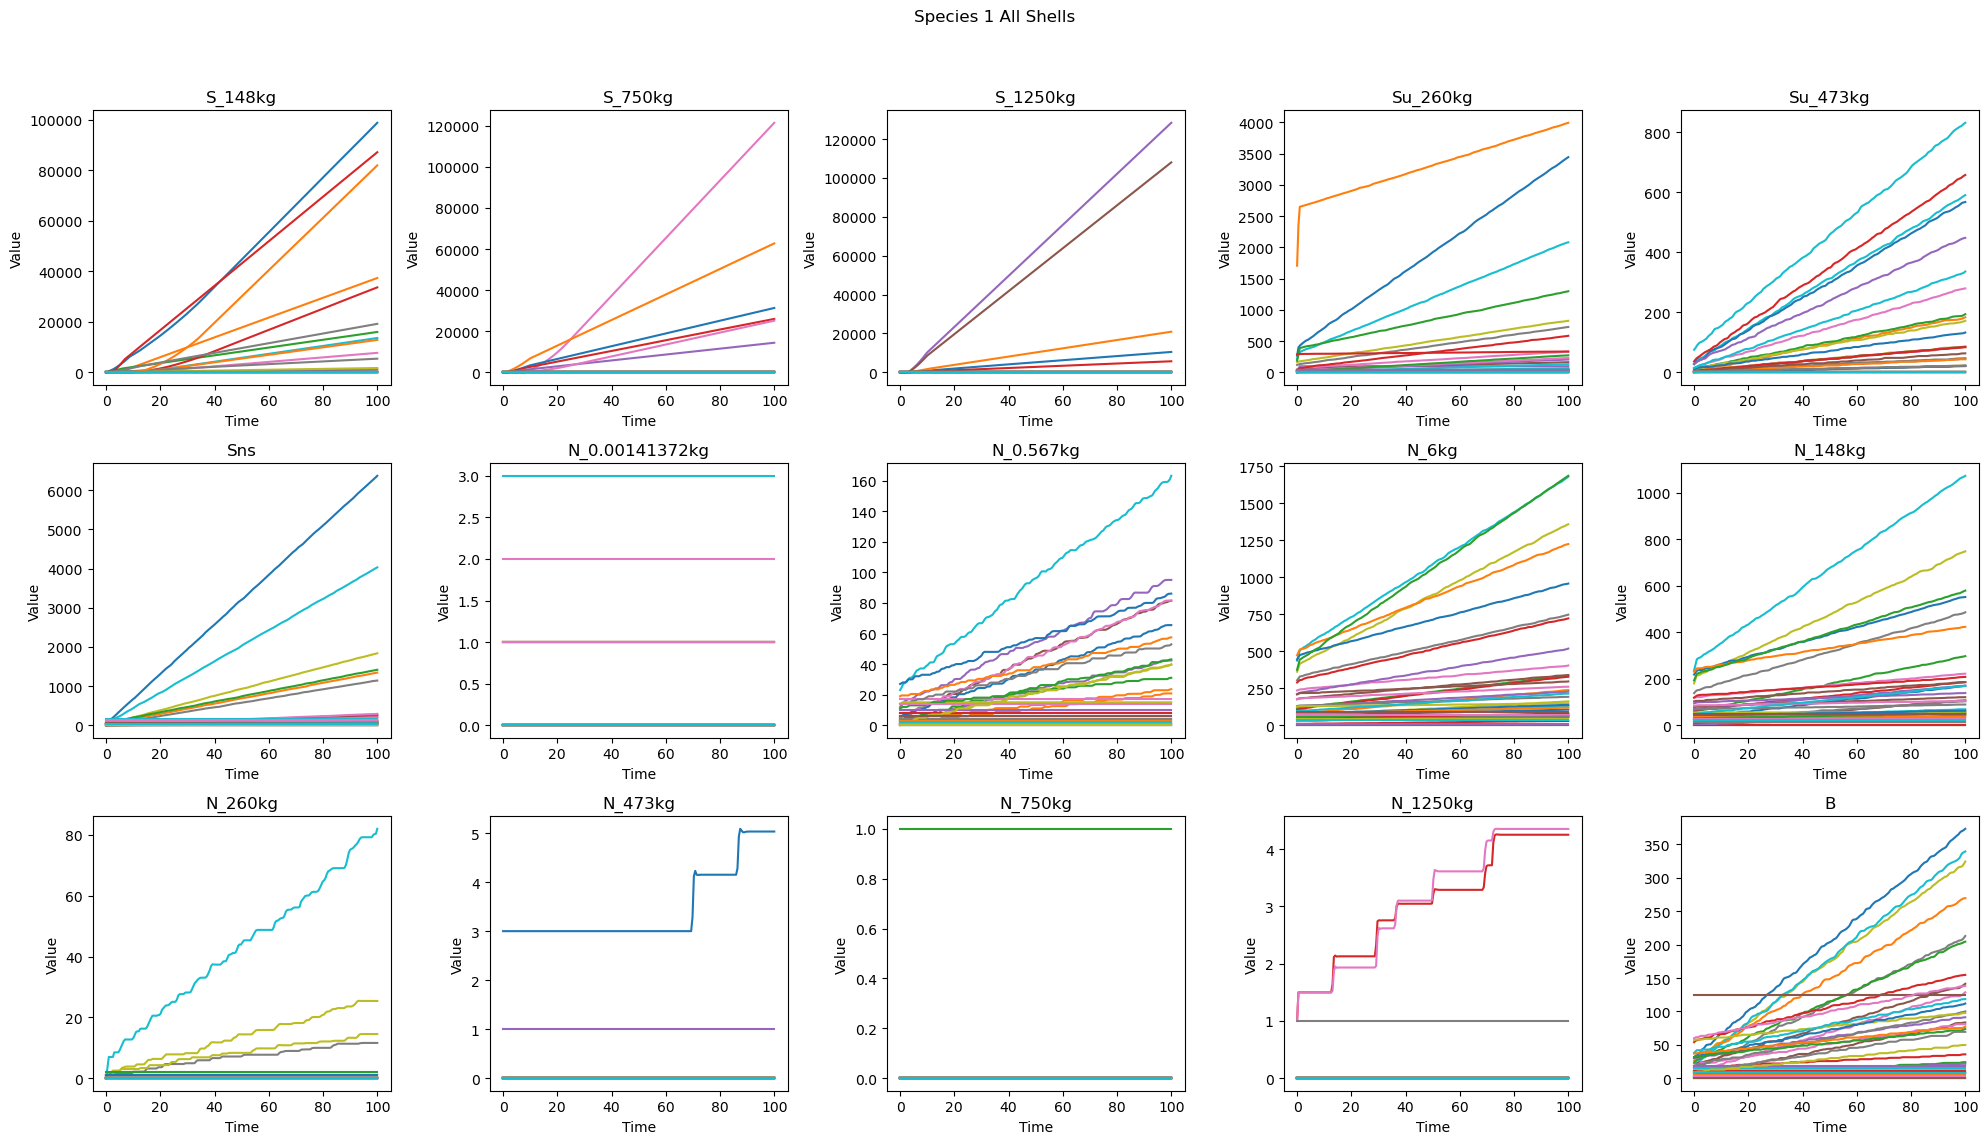

In [369]:
# Assuming 'output.y' has the shape (n_variables, n_time_points) and output.t are the time points
n_species = 15
shells_per_species = 40

# Set up the figure and axes
fig, axes = plt.subplots(3, 5, figsize=(20, 12))  # Adjust the size as needed

# Loop over each species
for species_index in range(n_species):
    ax = axes.flatten()[species_index]  # Get the current axis
    species_data = scenario_properties.output.y[species_index*shells_per_species:(species_index+1)*shells_per_species]

    # Plot each shell for this species
    for shell_index in range(shells_per_species):
        ax.plot(output.t, species_data[shell_index], label=f'Shell {shell_index+1}')

    # Calculate and plot the sum of all shells for this species
    total = np.sum(species_data, axis=0)
    #ax.plot(output.t, total, label='Total', linestyle='--', color='black')

    # Setting titles and labels
    ax.set_title(f'{scenario_properties.species_names[species_index]}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')

    # You may need to adjust or disable the legend if it's too crowded
    # ax.legend()

plt.suptitle('Species 1 All Shells')  # Set a super title for the entire figure
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the super title
plt.show()

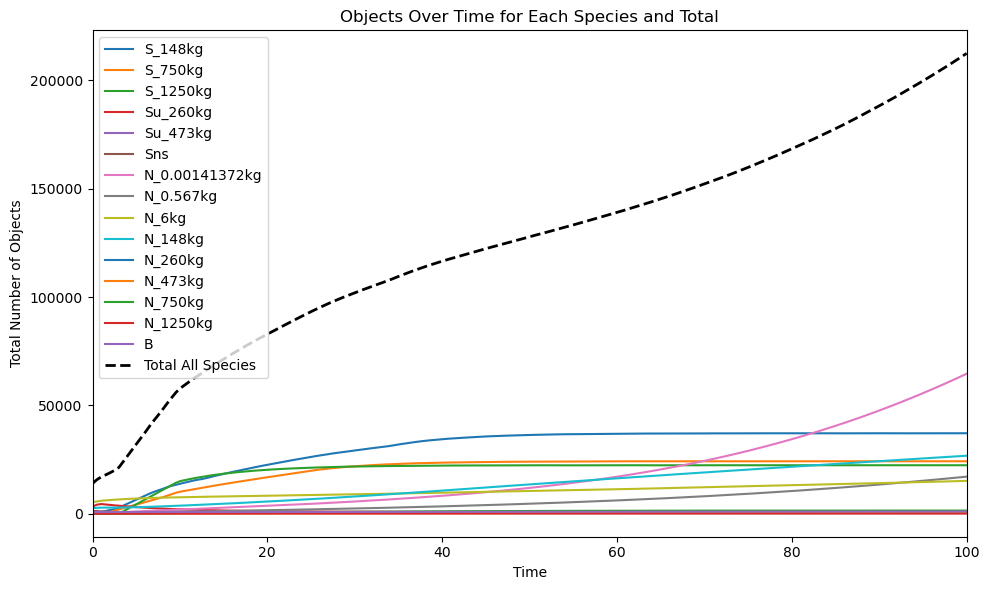

In [233]:
# Assuming scenario_properties.species_names is available
species_names = scenario_properties.species_names

plt.figure(figsize=(10, 6))

# Assuming output.y's shape is (n_variables, n_time_points) and is ordered by species
num_species = len(species_names)
num_shells = 40  # Number of shells per species

# Initialize an array to hold the total number of objects at each time point
total_objects_all_species = np.zeros_like(output.t)

# Sum and plot for each species, using species names for labels
for i in range(num_species):
    start_idx = i * num_shells
    end_idx = start_idx + num_shells
    total_objects_per_species = np.sum(output.y[start_idx:end_idx, :], axis=0)  # Sum along the vertical axis
    plt.plot(output.t, total_objects_per_species, label=f'{species_names[i]}')
    
    # Add to the total objects count
    total_objects_all_species += total_objects_per_species

# Plot the total sum line
plt.plot(output.t, total_objects_all_species, label='Total All Species', color='k', linewidth=2, linestyle='--')

plt.xlabel('Time')
plt.ylabel('Total Number of Objects')
plt.title('Objects Over Time for Each Species and Total')
plt.xlim(0, max(output.t))
# Adjust the ylim based on the range of total_objects_all_species if necessary
# plt.ylim(0, np.max(total_objects_all_species) * 1.1)

plt.legend()
plt.tight_layout()
plt.show()


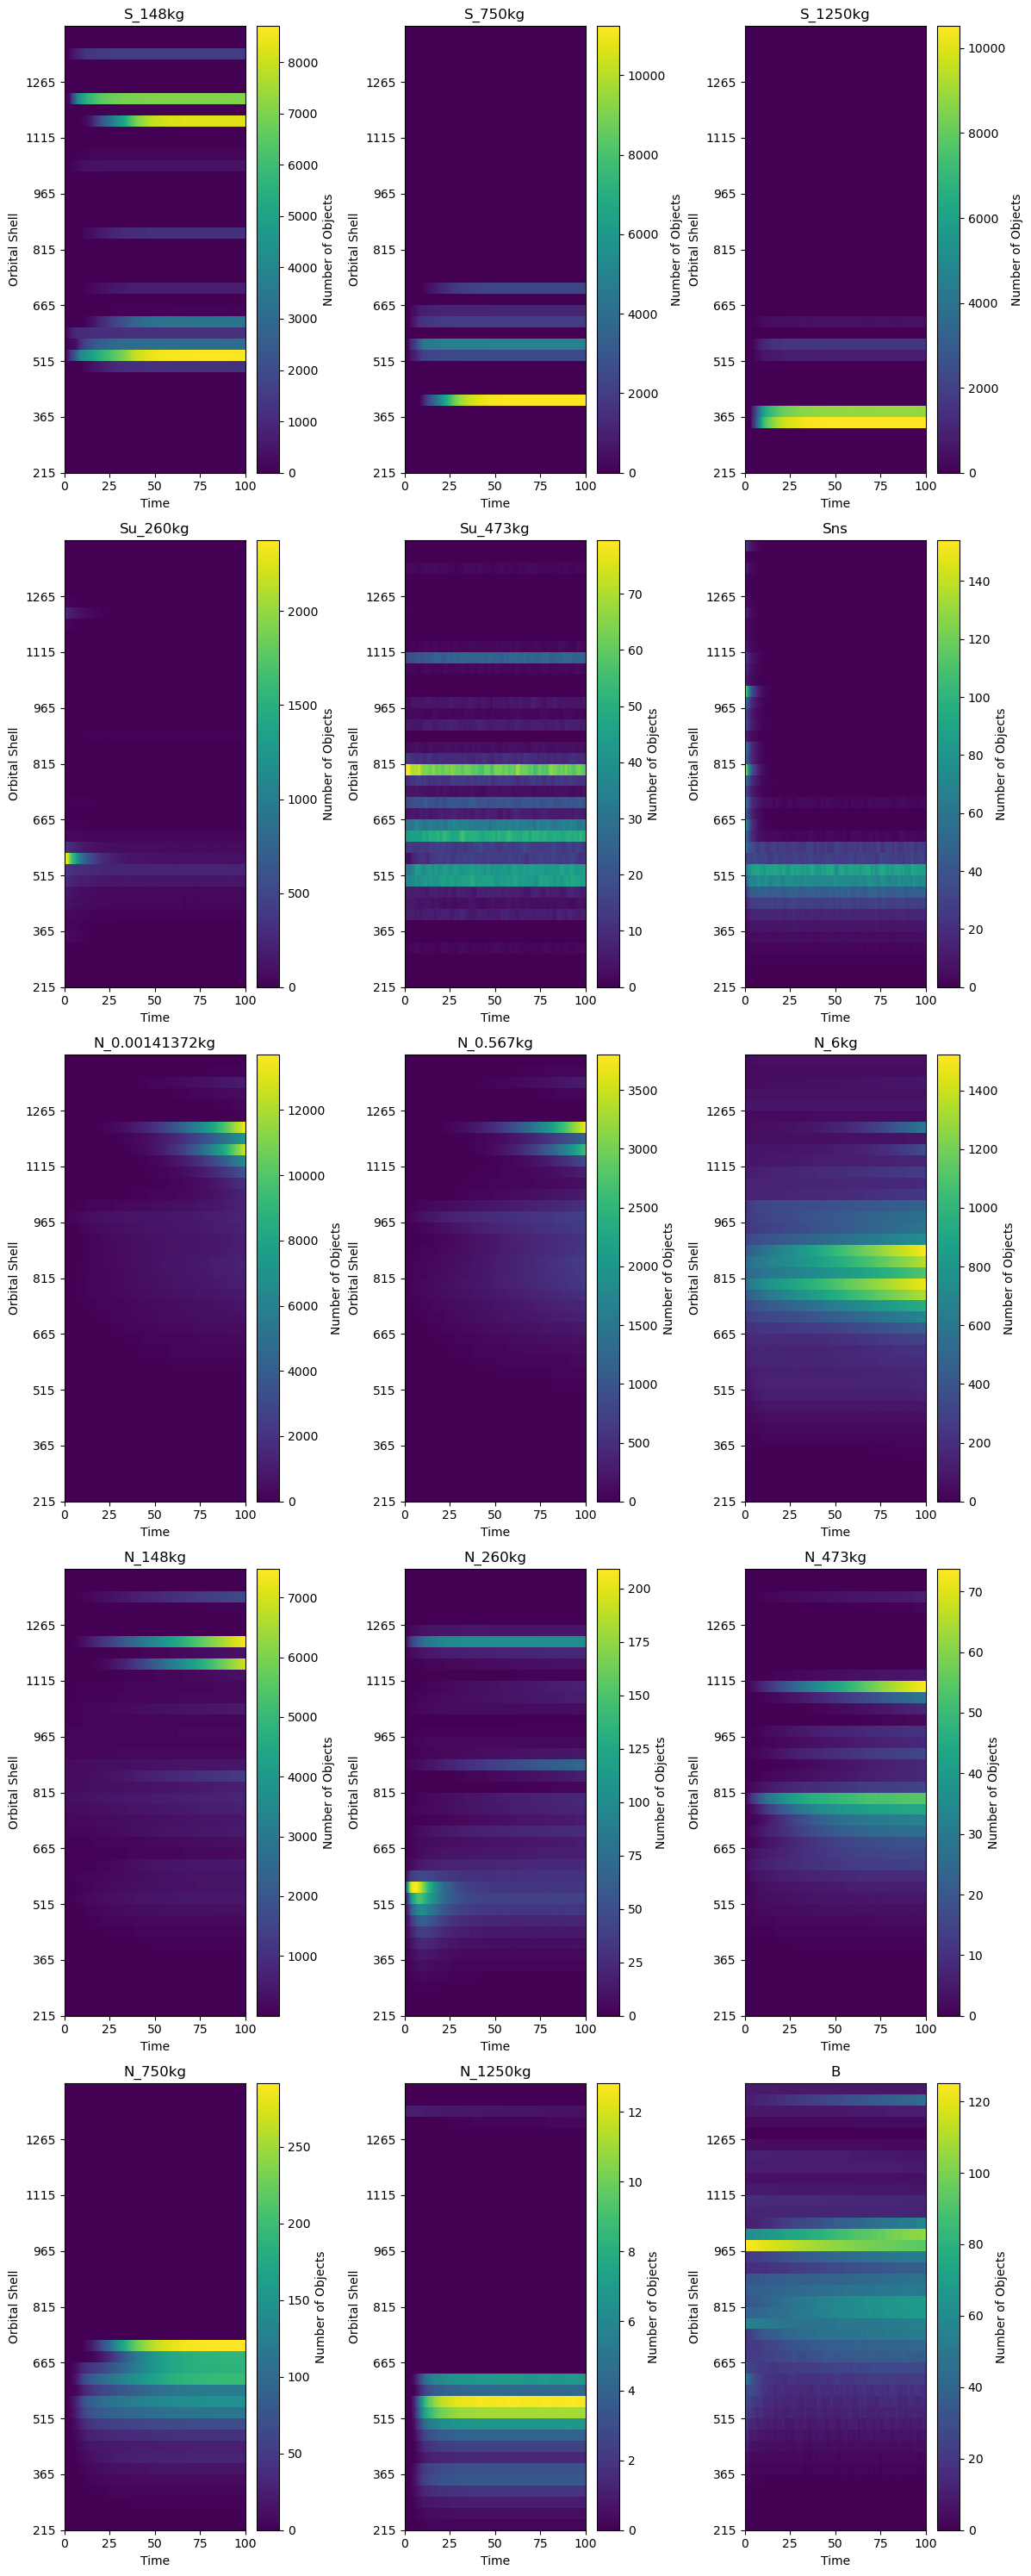

In [234]:
species_names = scenario_properties.species_names
num_species = len(species_names)
num_shells = 40  # Assuming this is constant for all species
n_time_points = len(output["t"])

# Determine the grid size based on the number of species
cols = 3  # Prefer a fixed number of columns
rows = np.ceil(num_species / cols).astype(int)

# Set up the figure and axes for the grid
fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(12, rows * 6))

for i, species_name in enumerate(species_names):
    # Calculate the position in the grid
    row = i // cols
    col = i % cols
    if rows == 1:
        ax = axs[col]  # When there's only one row, `axs` is a 1D array
    else:
        ax = axs[row, col]

    # Extract the data for the current species across all shells
    start_idx = i * num_shells
    end_idx = start_idx + num_shells
    data_per_species = output["y"][start_idx:end_idx, :]
    
    # Plotting the heatmap
    cax = ax.imshow(data_per_species, aspect='auto', origin='lower',
                    extent=[output["t"][0], output["t"][-1], 0, num_shells],
                    interpolation='nearest')
    fig.colorbar(cax, ax=ax, label='Number of Objects')
    ax.set_xlabel('Time')
    ax.set_ylabel('Orbital Shell')
    ax.set_title(species_name)
    ax.set_xticks(np.linspace(output["t"][0], output["t"][-1], num=5))
    ax.set_yticks(np.arange(0, num_shells, 5))
    ax.set_yticklabels([f'{alt:.0f}' for alt in scenario_properties.HMid[::5]])

# Adjust layout and hide any unused axes
for i in range(num_species, rows*cols):
    if rows == 1:
        fig.delaxes(axs[i])
    else:
        axs.flatten()[i].set_visible(False)

plt.tight_layout()
plt.show()

## Drag Visualisation

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import os

species_names = scenario_properties.species_names
num_species = len(species_names)
num_shells = 40  # Assuming this is constant for all species
n_time_points = len(output["t"])

# Create the directory if it doesn't exist
directory = 'plots/drag/'
os.makedirs(directory, exist_ok=True)

def update_hist(num, data, ax, species_name):
    ax.clear()
    ax.bar(range(1, num_shells + 1), data[:, num], color='b')
    ax.set_title(f'{species_name} - Time: {output["t"][num]:.2f}')
    ax.set_xlabel('Orbital Shell')
    ax.set_ylabel('Number of Objects')
    ax.set_ylim(0, np.max(data))  # Adjust y-axis to fit all data
    ax.grid(True, which='both', axis='y', linestyle='--', alpha=0.7)

for i, species_name in enumerate(species_names):
    fig, ax = plt.subplots(figsize=(10, 6))

    # Extract data for the current species across all shells and all time points
    start_idx = i * num_shells
    end_idx = start_idx + num_shells
    data_per_species = output["y"][start_idx:end_idx, :]
    
    # Create the animation
    ani = FuncAnimation(fig, update_hist, frames=n_time_points, fargs=(data_per_species, ax, species_name), repeat=False)

    # Save the animation as a GIF in the specified directory
    gif_path = os.path.join(directory, f'{species_name}_distribution.gif')
    ani.save(gif_path, writer='pillow', fps=10)  # Adjust fps as needed

    plt.close(fig)  # Close the plot to prevent display

### All in same plot

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import os

species_names = scenario_properties.species_names
num_species = len(species_names)
num_shells = 40  # Assuming this is constant for all species
n_time_points = len(output["t"])
shell_ids = scenario_properties.HMid  # Assuming this contains the identifiers for each shell

# Ensure that the length of HmID matches num_shells
if len(shell_ids) != num_shells:
    raise ValueError("The length of HmID does not match the number of shells")

# Determine the grid size based on the number of species
cols = 3  # You can adjust the number of columns based on your preference
rows = np.ceil(num_species / cols).astype(int)

# Create the directory if it doesn't exist
directory = 'plots/drag/'
os.makedirs(directory, exist_ok=True)

fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(cols * 5, rows * 4), tight_layout=True)

def update_hist(num):
    # This function updates all subplots in each frame
    for i in range(num_species):
        ax = axs.flatten()[i]
        ax.clear()
        start_idx = i * num_shells
        end_idx = start_idx + num_shells
        ax.bar(shell_ids, output["y"][start_idx:end_idx, num], color='b')
        ax.set_title(f'{species_names[i]} - Time: {output["t"][num]:.2f}')
        ax.set_xlabel('Orbital Shell ID')
        ax.set_ylabel('Number of Objects')
        # Set y lim to fit just this species
        ax.set_ylim(0, np.max(output["y"][start_idx:end_idx, :]))
        #ax.set_ylim(0, np.max(output["y"]))  
        ax.grid(True)

    # Hide any unused axes
    for j in range(num_species, rows * cols):
        axs.flatten()[j].set_visible(False)

# Create the animation
ani = FuncAnimation(fig, update_hist, frames=n_time_points, repeat=False)

# Save the animation as a GIF in the specified directory
gif_path = os.path.join(directory, 'all_species_distribution.gif')
ani.save(gif_path, writer='pillow', fps=5)  # Adjust fps as needed

plt.close(fig)  # Close the plot to prevent display

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import os

species_names = ['S_148kg', 'S_750kg', 'S_1250kg', 'Su_260kg', 'Su_473kg', 'sns', 'N_0.00141372kg', 'N_0.567kg', 'N_6kg', 'N_148kg', 'N_260kg', 'N_473kg', 'N_750kg', 'N_1250kg', 'B']
num_species = len(species_names)
num_shells = 40  # Assuming this is constant for all species
n_time_points = len(output["t"])
shell_ids = scenario_properties.HMid  # Assuming this contains the identifiers for each shell

# Categorize species into satellites and debris
satellite_species = [name for name in species_names if name[0].lower() == 's']
debris_species = [name for name in species_names if name[0].lower() != 's']

# Function to create directory and animation
def create_animation(species_list, category):
    directory = f'plots/drag/{category}/'
    os.makedirs(directory, exist_ok=True)
    
    for species_name in species_list:
        i = species_names.index(species_name)
        fig, ax = plt.subplots(figsize=(10, 6))
        data_per_species = output["y"][i * num_shells: (i + 1) * num_shells, :]

        def update_hist(num):
            ax.clear()
            ax.bar(shell_ids, data_per_species[:, num], color='b')
            ax.set_title(f'{species_name} - Time: {output["t"][num]:.2f}')
            ax.set_xlabel('Orbital Shell ID')
            ax.set_ylabel('Number of Objects')
            #ax.set_ylim(0, np.max(output["y"]))  # Set the y-limit to max of all data
            ax.grid(True)

        # Create the animation
        ani = FuncAnimation(fig, update_hist, frames=n_time_points, repeat=False)

        # Save the animation as a GIF in the specified directory
        gif_path = os.path.join(directory, f'{species_name}_distribution.gif')
        ani.save(gif_path, writer='pillow', fps=5)  # Adjust fps as needed

        plt.close(fig)  # Close the plot to prevent display

# Create animations for each category
create_animation(satellite_species, 'satellites')
create_animation(debris_species, 'debris')

### Collisions

## Comparison and Validation to MATLAB

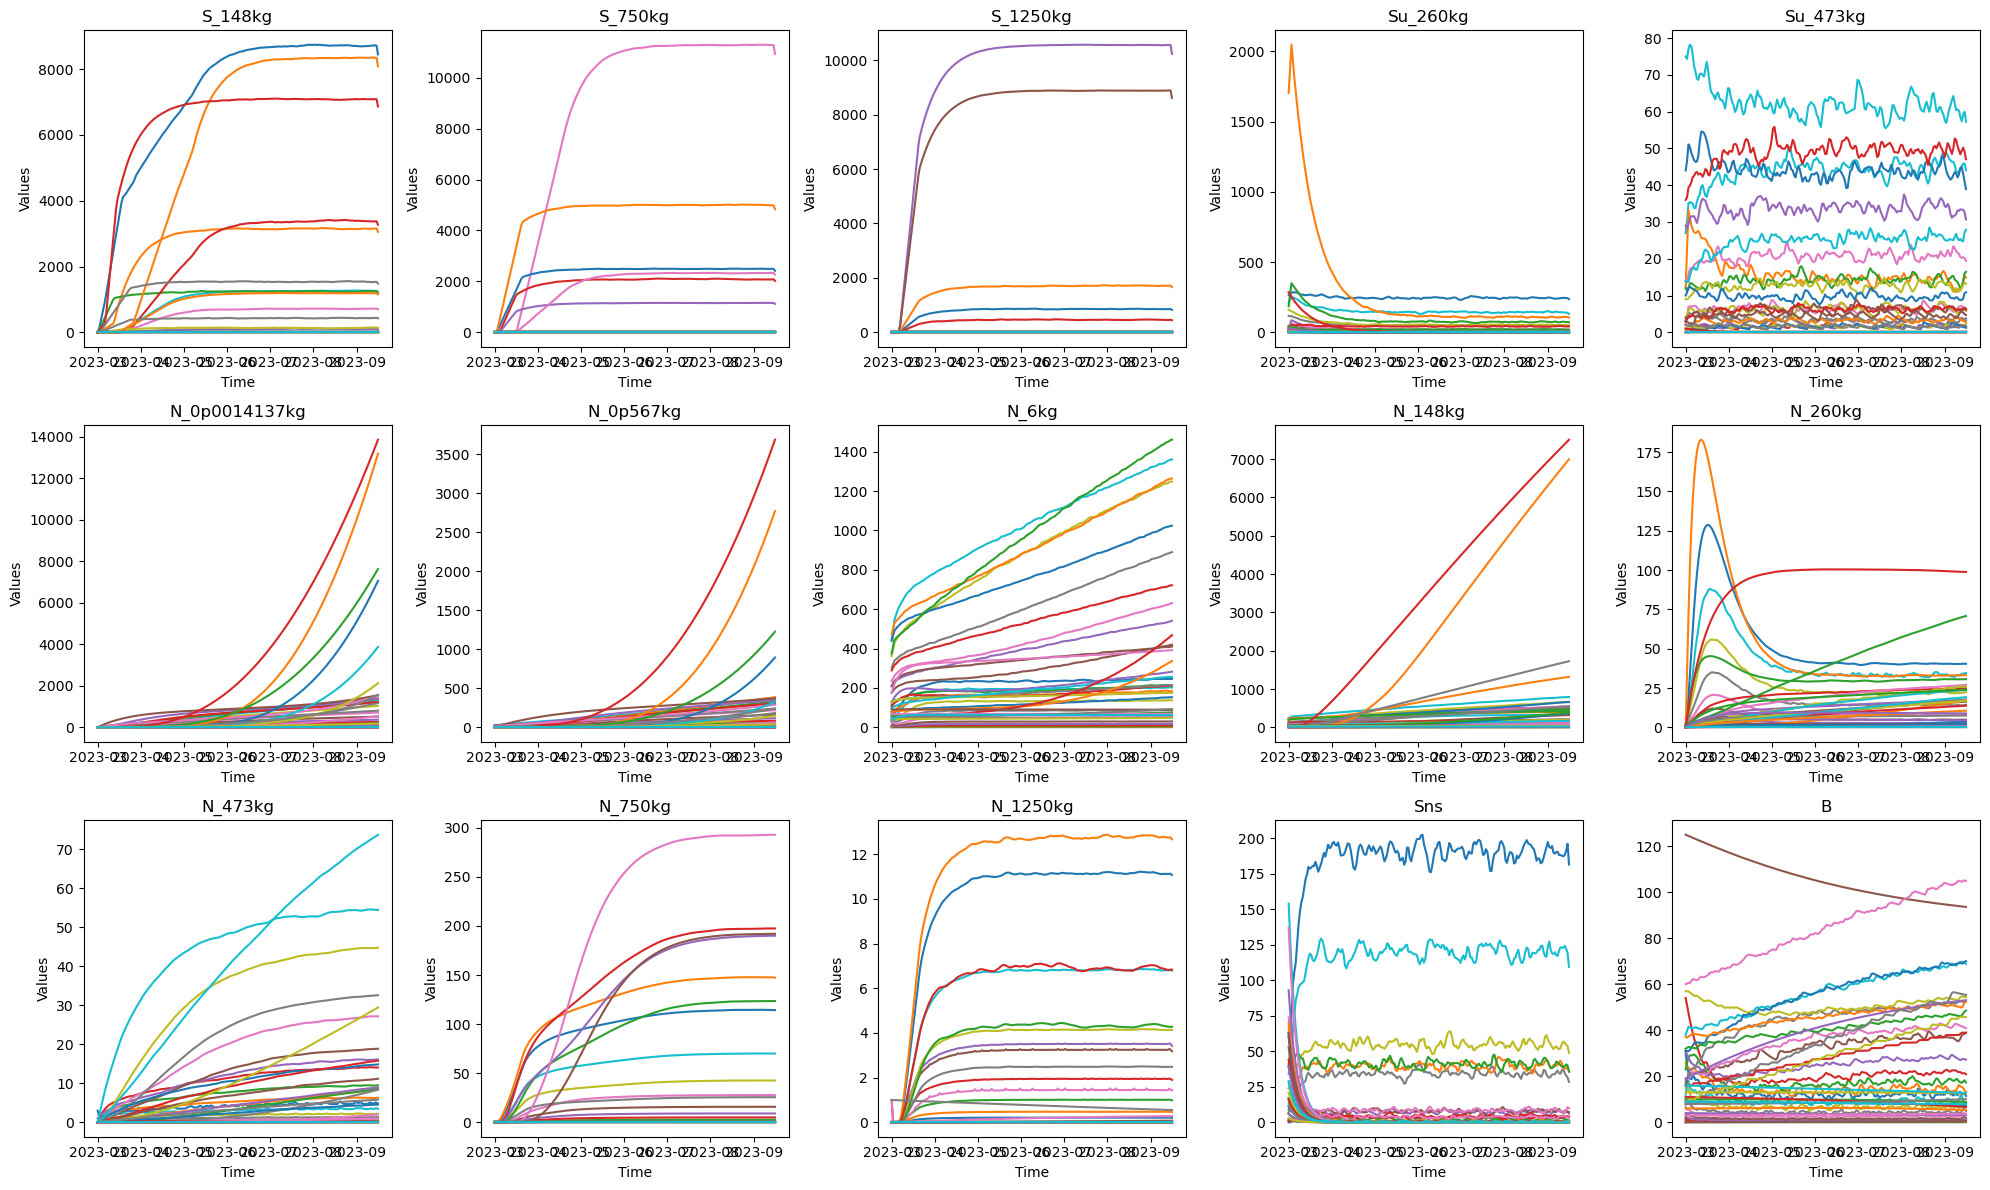

In [327]:
with open(r'D:\ucl\pyssem\src\pyssem\utils\launch\data\data.json') as f:
    data_json = json.load(f)

extended_times = np.tile(scenario_properties.scen_times, 40)
df = pd.DataFrame(index=pd.Index(extended_times, name='Time'))

for species in data_json:
    species_key = species['key']
    species_data = species['value']  # This is a list of 200 lists, each inner list has 40 entries

    # Flatten the nested list structure to align with the DataFrame rows
    flat_data = [item for sublist in species_data for item in sublist]

    # Add the data to the DataFrame
    df[species_key] = flat_data

# Number of shells and time steps
num_shells = 40
num_timesteps = 200
time_index = pd.date_range(start='2023-03-01', periods=num_timesteps, freq='D')

# Setting up the grid
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 12))  # Create a figure with a 3x5 grid of axes
axes = axes.flatten()  # Flatten the array of axes for easier indexing

# Plot each column (each species) in its subplot
for i, column in enumerate(df.columns):
    if i >= len(axes):  # Check if there are more species than grid spaces
        break
    ax = axes[i]  # Get the current Axes instance

    # Plot each orbital shell
    for shell in range(num_shells):
        shell_data = df[column].iloc[shell::num_shells]  # Data for one shell across all times
        ax.plot(time_index, shell_data, label=f'Shell {shell + 1}')

    ax.set_title(f'{column}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Values')
    # if i == 0 or i % 5 == 0:  # Add legend to only the first column to save space
    #     ax.legend(title='Orbital Shell', bbox_to_anchor=(1.05, 1), loc='upper left')

# Hide any unused axes if there are less than 15 species
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


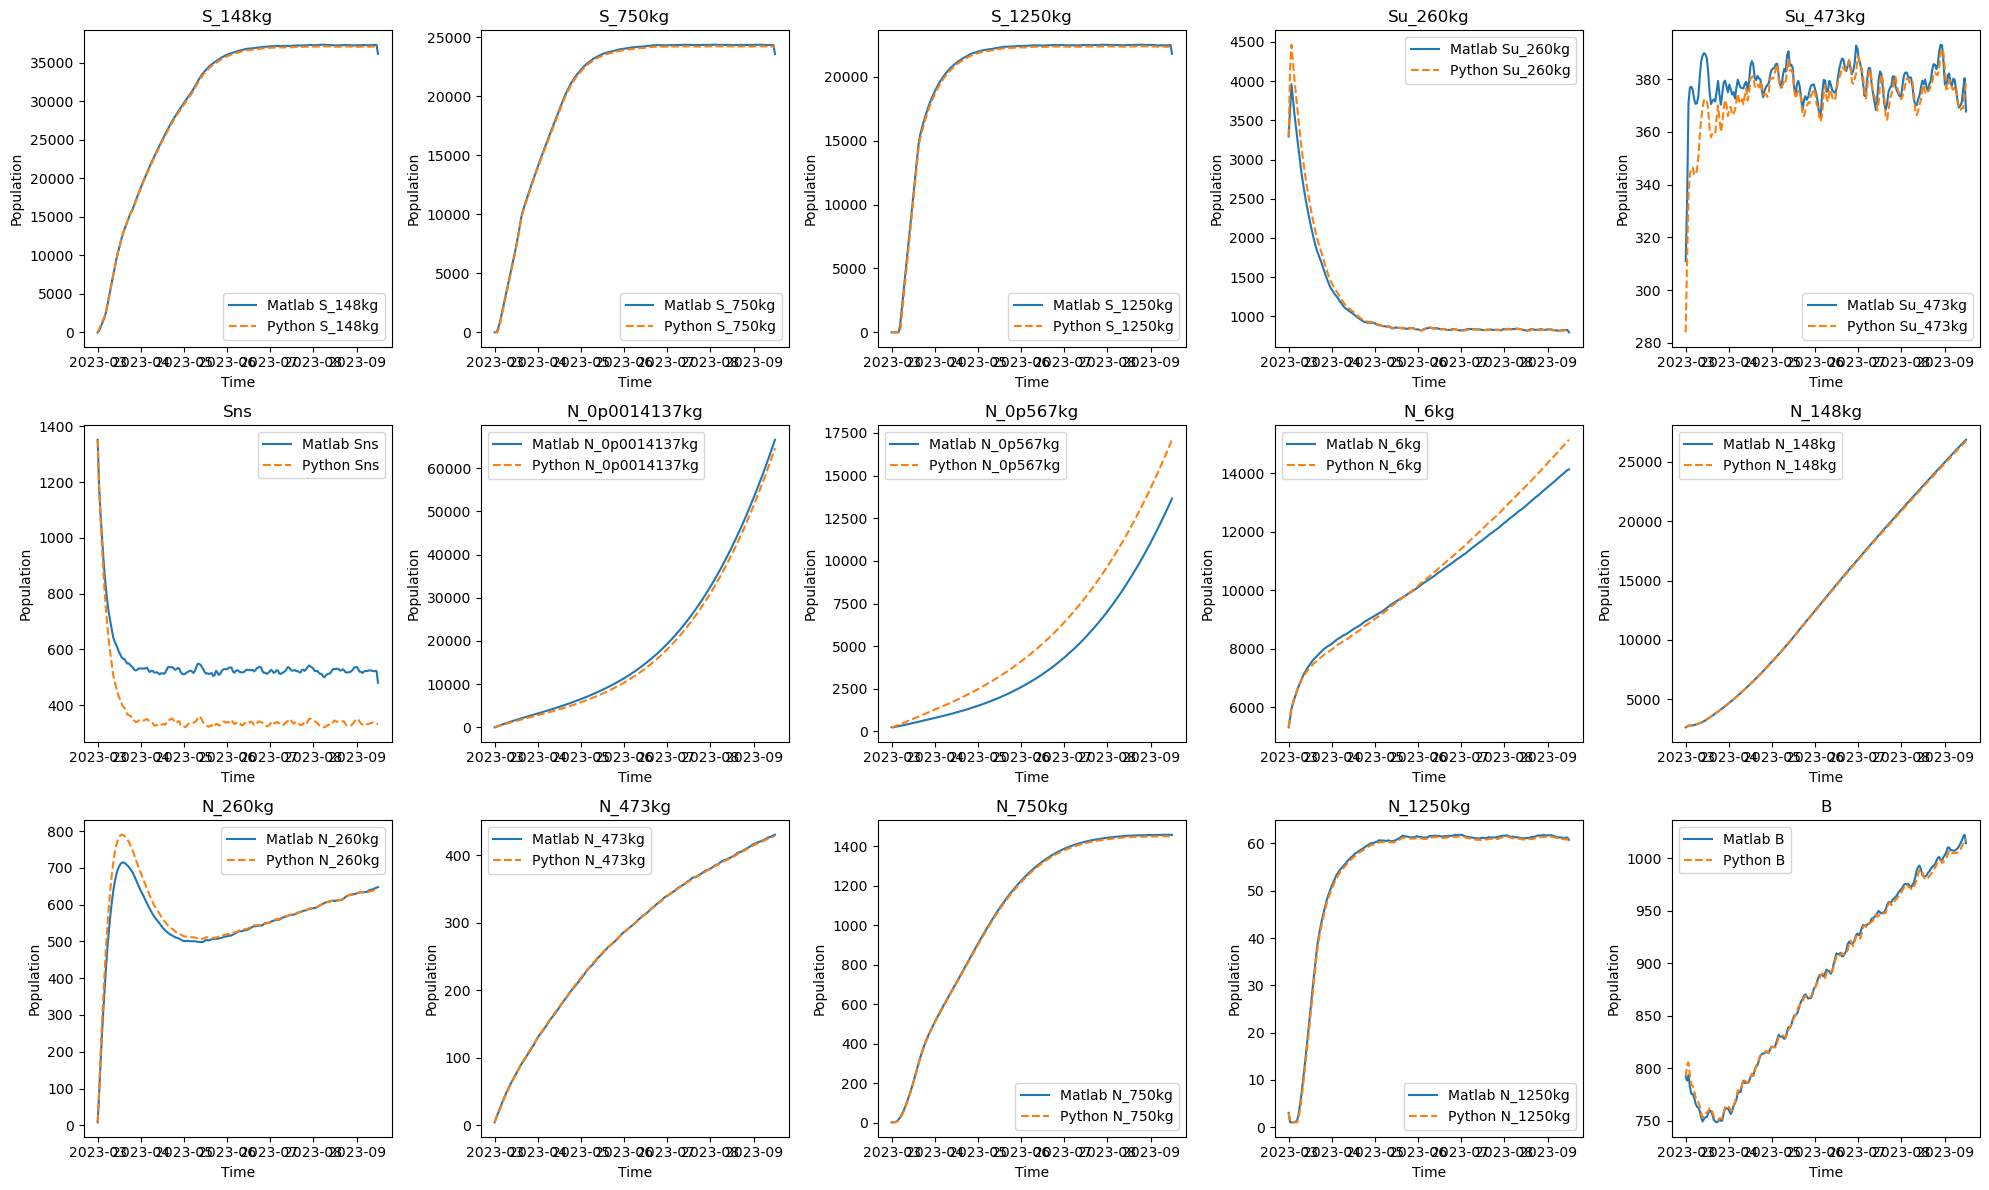

In [334]:
# Set up the figure and axes for the 3x5 grid
fig, axes = plt.subplots(3, 5, figsize=(20, 12))
axes = axes.flatten()

# Loop over each species using the species_names for labeling and data_json for data
for species_index, species_name in enumerate(scenario_properties.species_names):
    ax = axes[species_index]  # Get the current axis

    # Extract the column name from data_json that matches the species_name
    species_key = next((item['key'] for item in data_json if species_name in item['key']), None)
    
    # Check if the species_key is valid (exists in data_json and df)
    if species_key and species_key in df.columns:
        # Plot observed data from df
        observed_data = df[species_key].values.reshape(-1, num_shells).sum(axis=1)
        ax.plot(time_index, observed_data, label=f'Matlab {species_name}')

        # Plot simulated data from output.y
        # Find the index in the output.y that corresponds to the current species
        simulated_data_index = scenario_properties.species_names.index(species_name) * num_shells
        simulated_data = output.y[simulated_data_index:simulated_data_index+num_shells, :].sum(axis=0)
        ax.plot(time_index, simulated_data, label=f'Python {species_name}', linestyle='--')

        # Customize subplot
        ax.set_title(species_name)
        ax.set_xlabel('Time')
        ax.set_ylabel('Population')
        ax.legend()

# Hide any unused axes
for j in range(species_index + 1, len(axes)):
    axes[j].set_visible(False)

# Adjust layout to fit everything
plt.tight_layout()
plt.show()

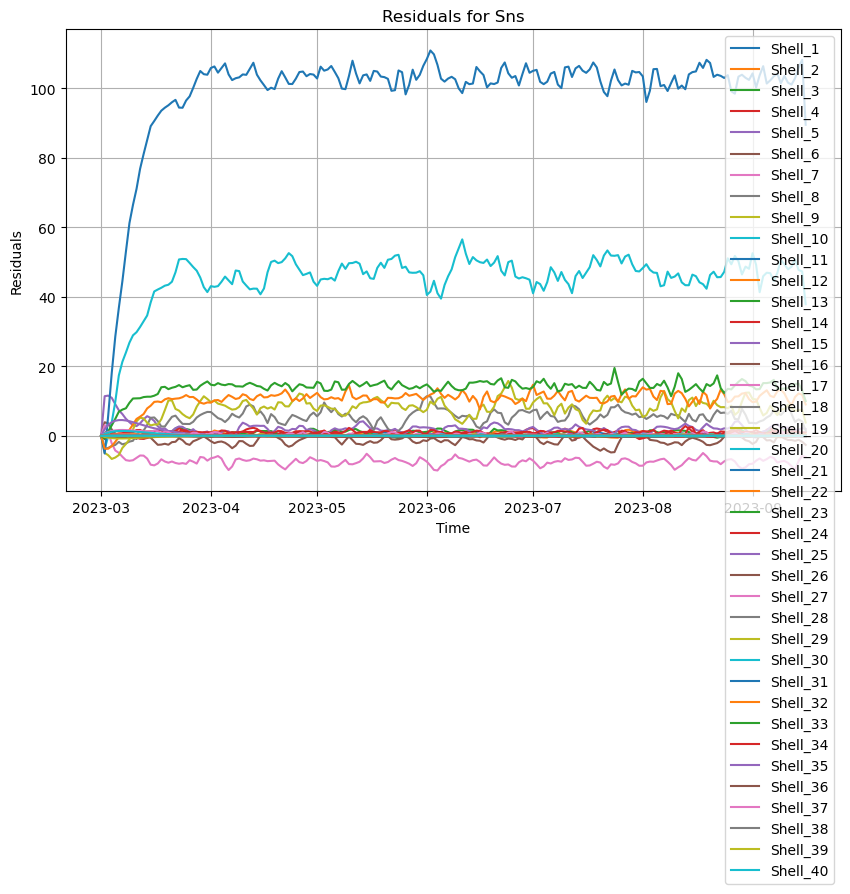

In [362]:
import matplotlib.pyplot as plt
import pandas as pd

# Choose a species to plot the residuals for
species_to_plot = scenario_properties.species_names[5]  # Change this index as needed

# Initialize an empty DataFrame to store residuals for the chosen species
species_residuals_df = pd.DataFrame(index=time_index)

# Loop over each species and each shell
for species_index, species_name in enumerate(scenario_properties.species_names):
    species_key = next((item['key'] for item in data_json if species_name in item['key']), None)
    
    if species_key and species_key in df.columns and species_name == species_to_plot:
        # Get observed data for this species
        observed_data = df[species_key].values.reshape(-1, num_shells)

        for shell_index in range(num_shells):
            # Get simulated data for this shell
            simulated_data_index = species_index * num_shells + shell_index
            simulated_shell_data = output.y[simulated_data_index, :]

            # Compute residuals for this shell and aggregate them
            residuals = observed_data[:, shell_index] - simulated_shell_data
            species_residuals_df[f'Shell_{shell_index+1}'] = residuals

# Plot all residuals for the chosen species on the same plot
plt.figure(figsize=(10, 6))
for column in species_residuals_df.columns:
    plt.plot(time_index, species_residuals_df[column], label=column)

plt.title(f'Residuals for {species_to_plot}')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True)
plt.show()